# 0.0 IMPORTS

## packages

In [196]:
import os, pickle, datetime, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import models as ml
from keras import layers as l
from scipy import stats as ss
import sweetviz as sv
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
from imblearn import under_sampling as us


pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\airbnb_prediction'

## 0.1 Helper Function

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [110]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2 Loading Data

In [3]:
df0 = pd.read_csv("data/train_users_2.csv")
df0.columns = df0.columns.str.lower()
df0.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [4]:
df_sessions = pd.read_csv( "data/sessions.csv" )
df_sessions.columns = df_sessions.columns.str.lower()
df_sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.00000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.00000


# 1.0 Data Description

In [92]:
df1 = df0.copy()

In [93]:
df_sessions1 = df_sessions.copy()

In [94]:
df1.shape

(213451, 16)

## 1.1 Check and Fill NAs

In [95]:
df1.isnull().sum()/len(df1)

id                        0.00000
date_account_created      0.00000
timestamp_first_active    0.00000
date_first_booking        0.58347
gender                    0.00000
age                       0.41223
signup_method             0.00000
signup_flow               0.00000
language                  0.00000
affiliate_channel         0.00000
affiliate_provider        0.00000
first_affiliate_tracked   0.02841
signup_app                0.00000
first_device_type         0.00000
first_browser             0.00000
country_destination       0.00000
dtype: float64

C:\Users\kosmo\AppData\Local\Temp\ipykernel_23296\3571433752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[df1['age']<65]['age'])


<Axes: xlabel='age', ylabel='Density'>

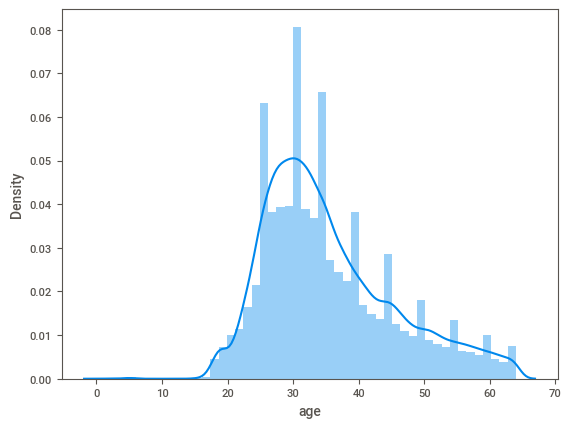

In [96]:
sns.distplot(df1[df1['age']<65]['age'])

In [97]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [98]:
# date first booking
for i in ["date_account_created", "date_first_booking"]:
    df1[i] = pd.to_datetime(df1[i])
date_first_booking_max = df1['date_first_booking'].max().strftime( "%Y-%m-%d" )
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1['age'] = df1['age'].fillna(df1['age'].mean())

print(df1['date_first_booking'].isnull().sum(), print(df1['age'].isnull().sum()))


# first_affiliate tracked
print( len(df1) )
df1 = df1[df1['first_affiliate_tracked'].notnull()]
print( len(df1) )

0
0 None
213451
207386


In [99]:
df1.isnull().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [100]:
df_sessions1.isnull().sum() / len(df_sessions1)

user_id         0.00326
action          0.00753
action_type     0.10657
action_detail   0.10657
device_type     0.00000
secs_elapsed    0.01287
dtype: float64

In [101]:
for i in df_sessions1.columns:
    df_sessions1 = df_sessions1[df_sessions1[i].notnull()]
    print( "tamanho:", len(df_sessions1))

tamanho: 10533241
tamanho: 10453761
tamanho: 9330804
tamanho: 9330804
tamanho: 9330804
tamanho: 9213930


## 1.2 Change Data Types

In [102]:
df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )


In [103]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [104]:

df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )
df1['age'] = df1['age'].astype(int)
print( df1.dtypes )

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object


In [105]:
print( len(df1) )
df1 = df1.dropna()
print( len(df1) )

207386
207386


## 1.3 Check Balanced Data

In [106]:
df1['country_destination'].value_counts( normalize=True )

NDF     0.57967
US      0.29446
other   0.04813
FR      0.02362
IT      0.01346
GB      0.01107
ES      0.01067
CA      0.00671
DE      0.00502
NL      0.00362
AU      0.00254
PT      0.00103
Name: country_destination, dtype: float64

## 1.4 Descriptive Analysis

p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: id                                  |▌         | [  6%]   00:01 -> (00:26 left)p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
Feature: date_account_created                |█▏        | 


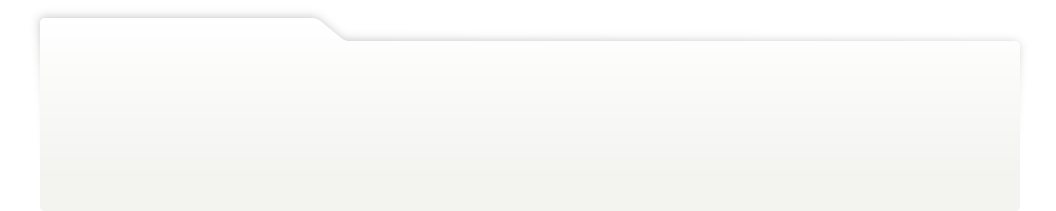
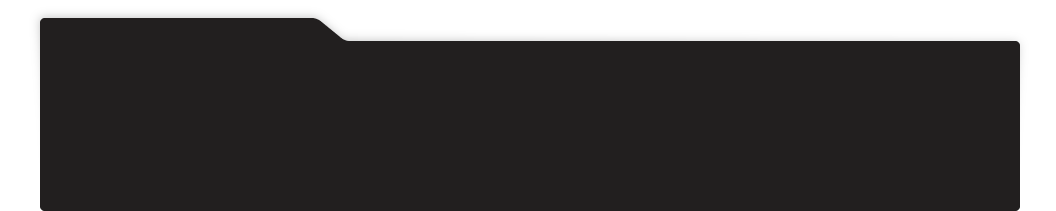
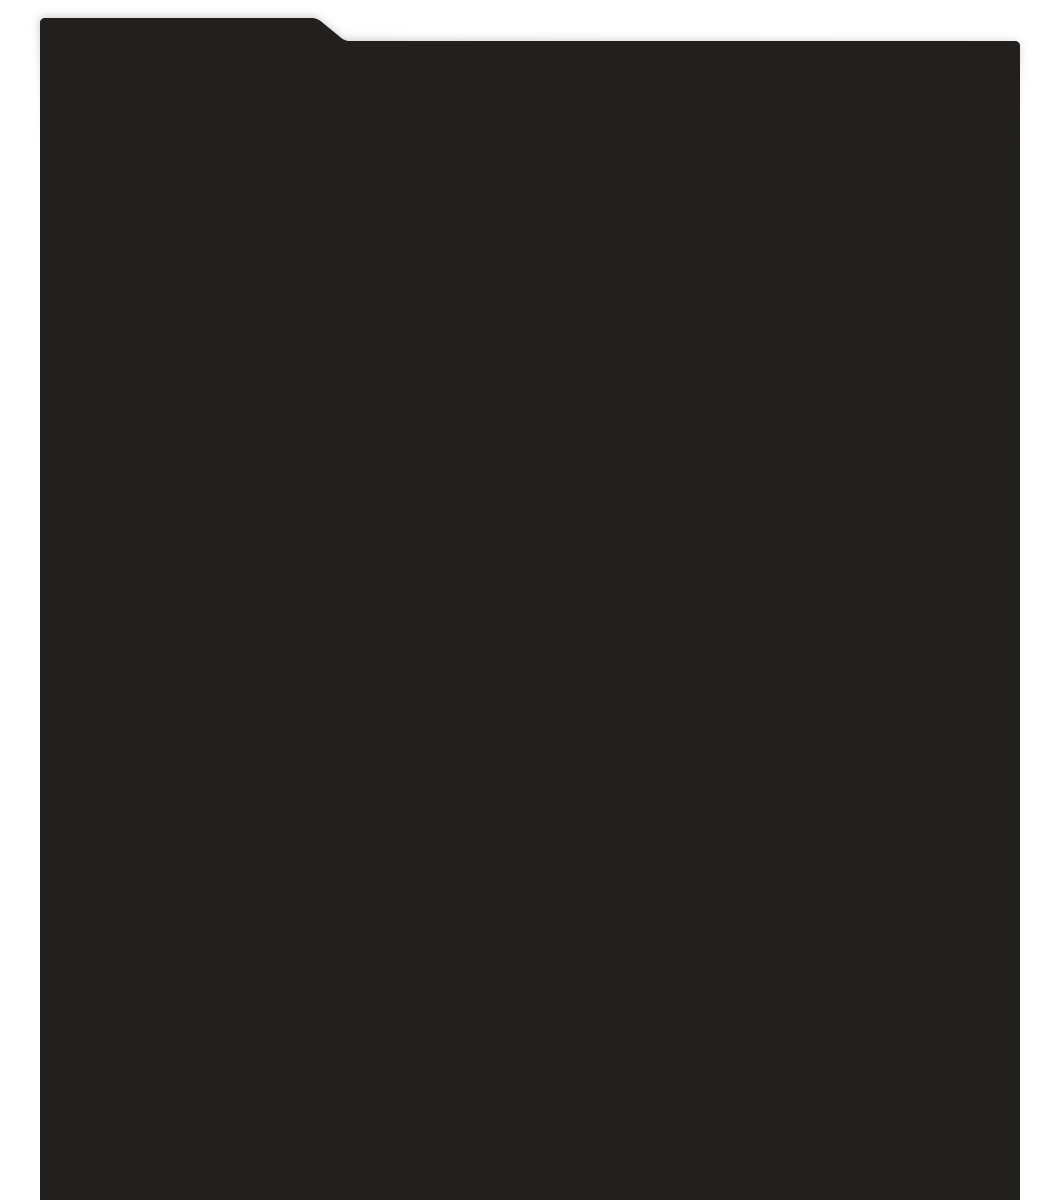
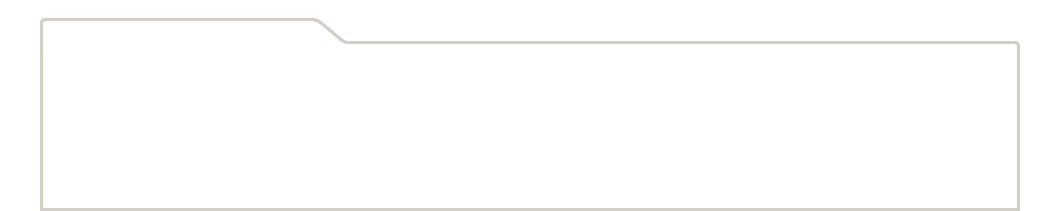
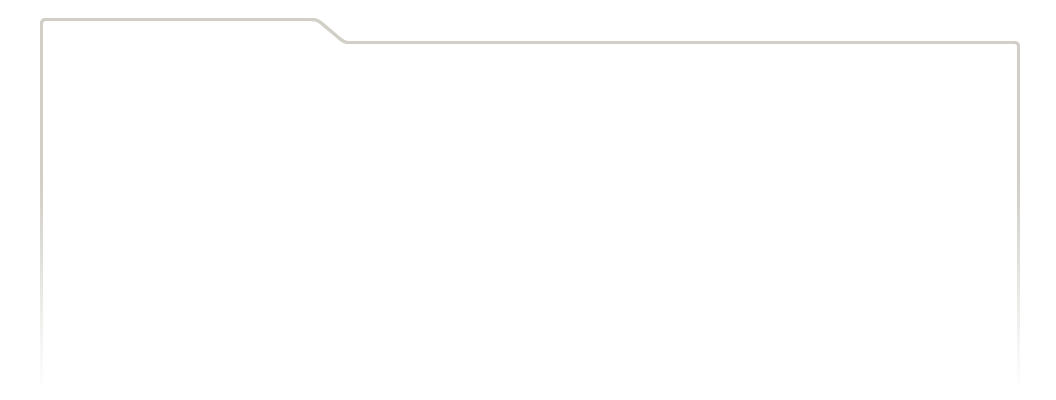
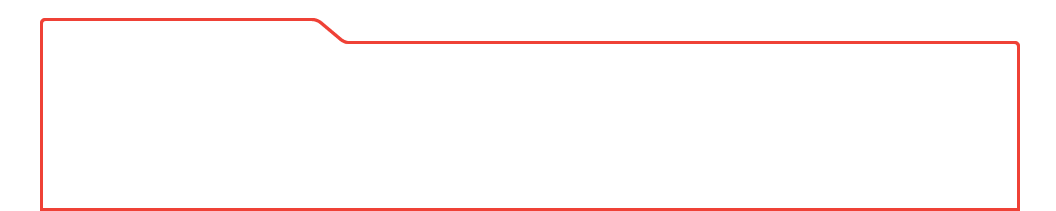
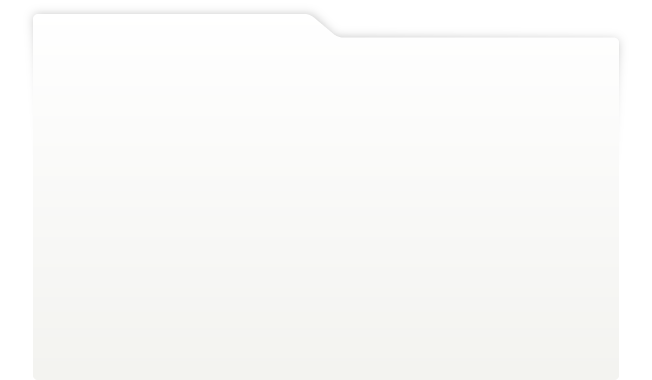
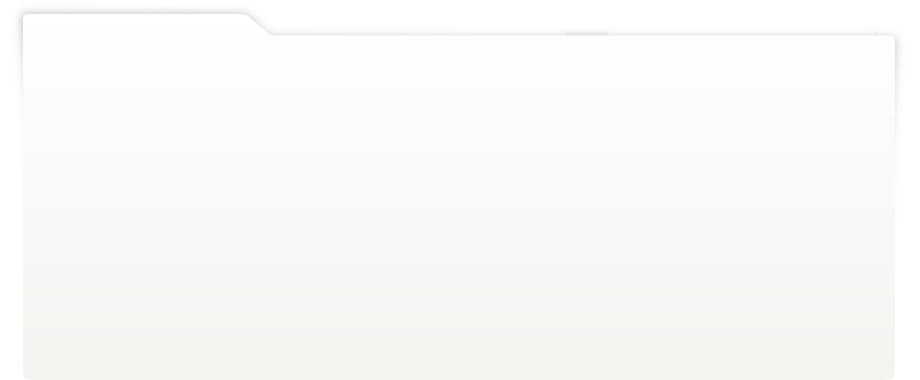
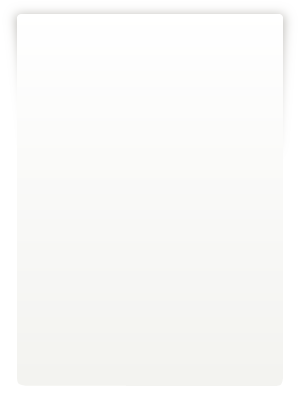
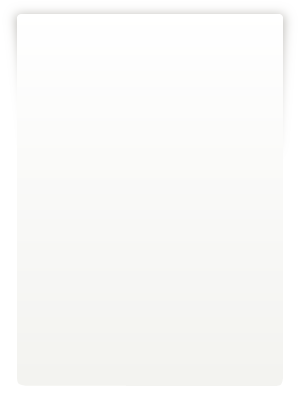
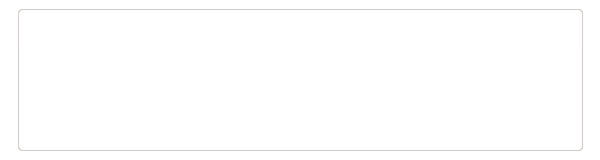
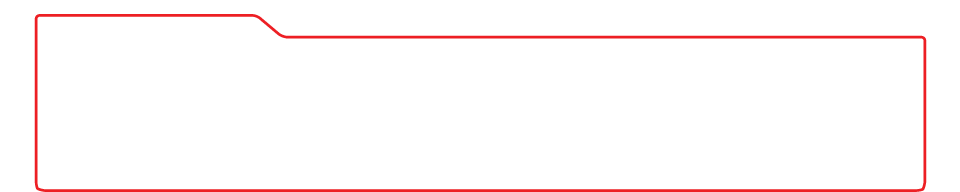
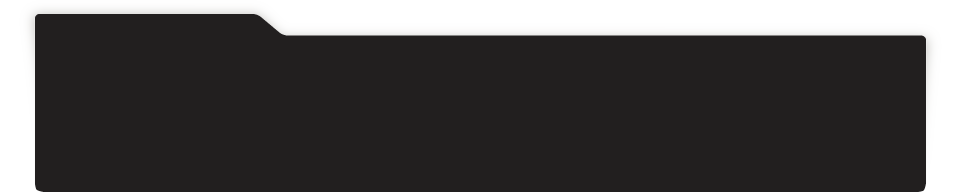
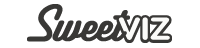
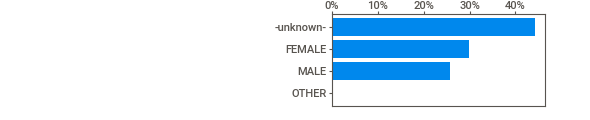
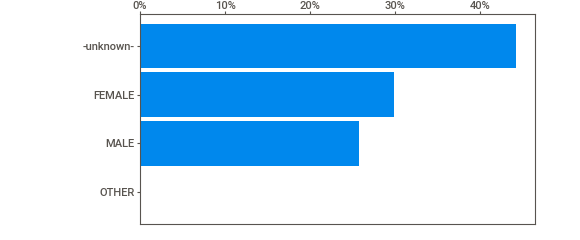
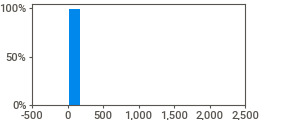
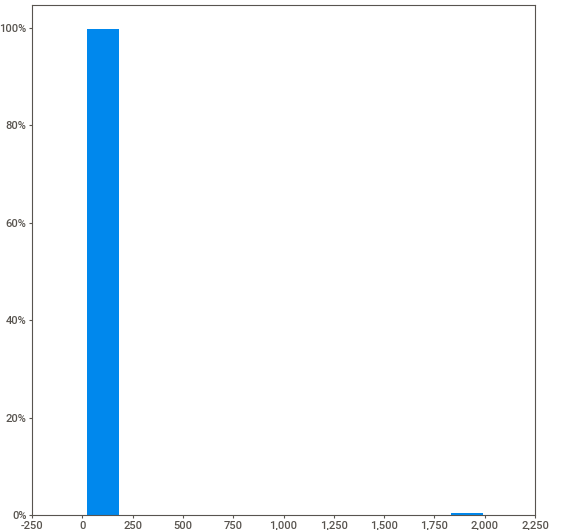
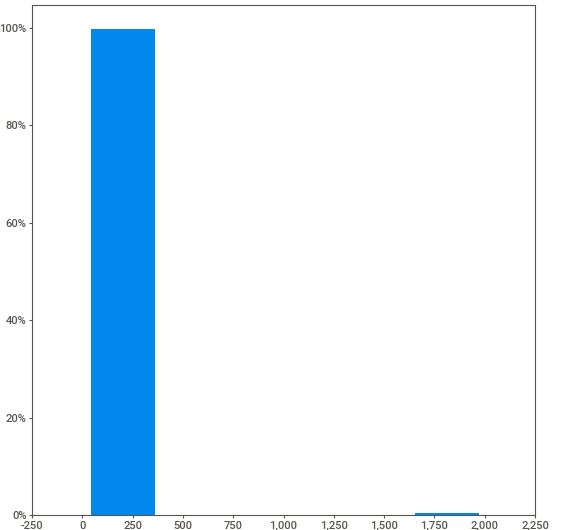
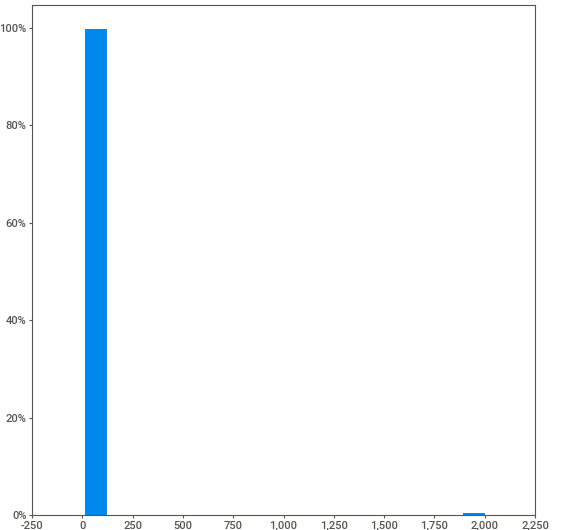
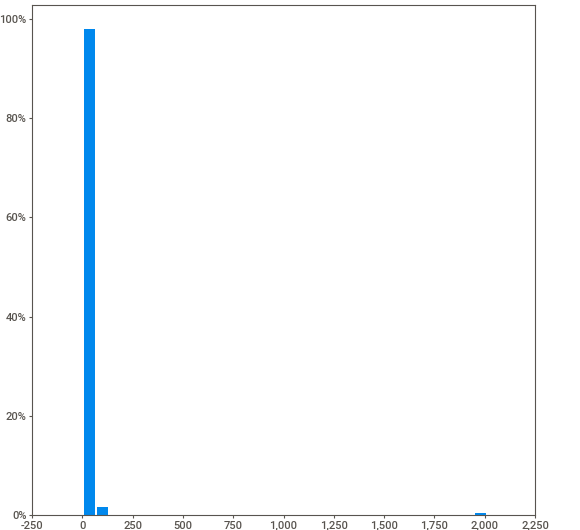
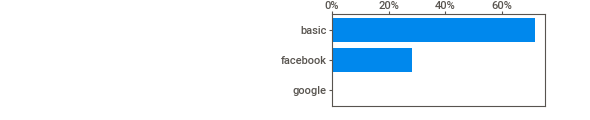
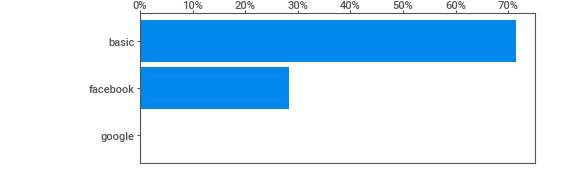
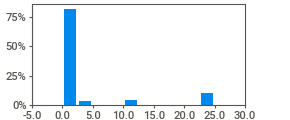
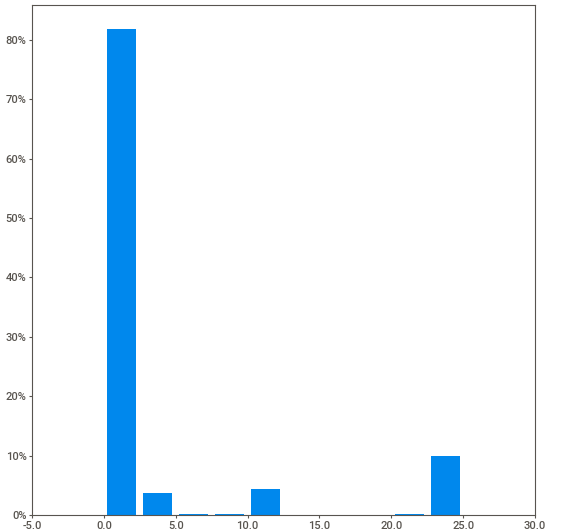
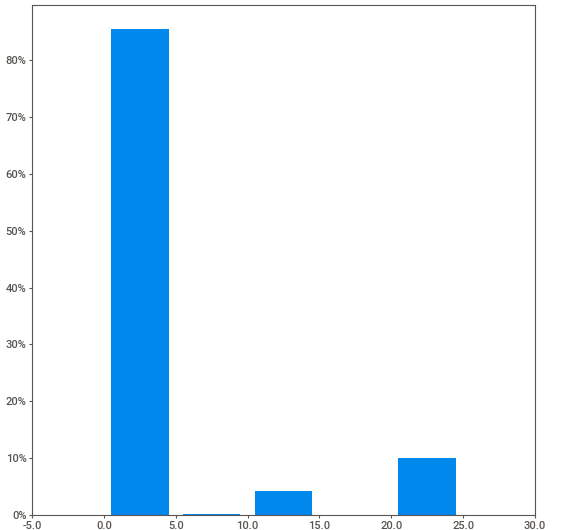
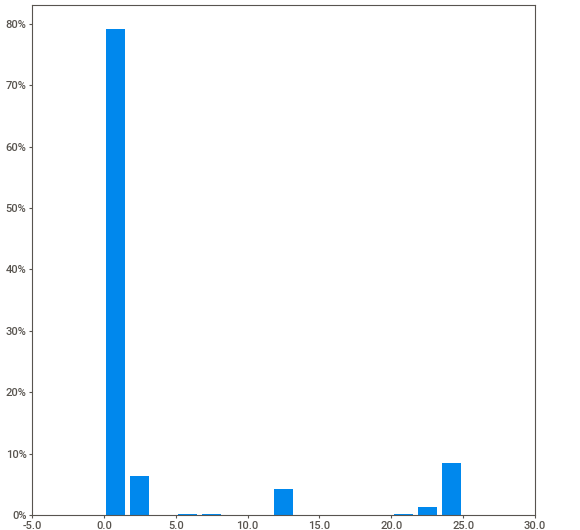
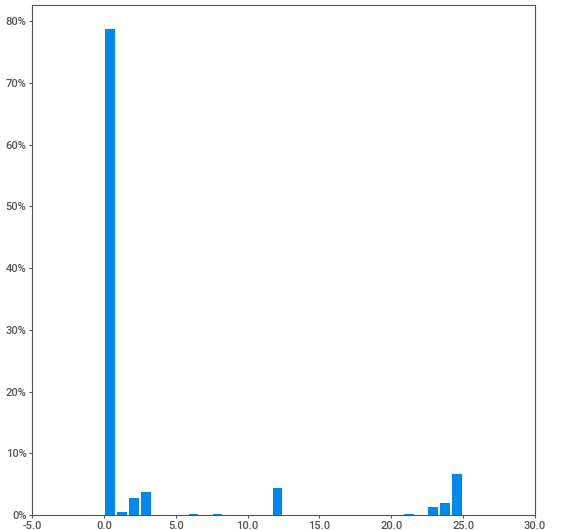
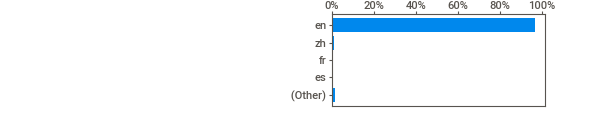
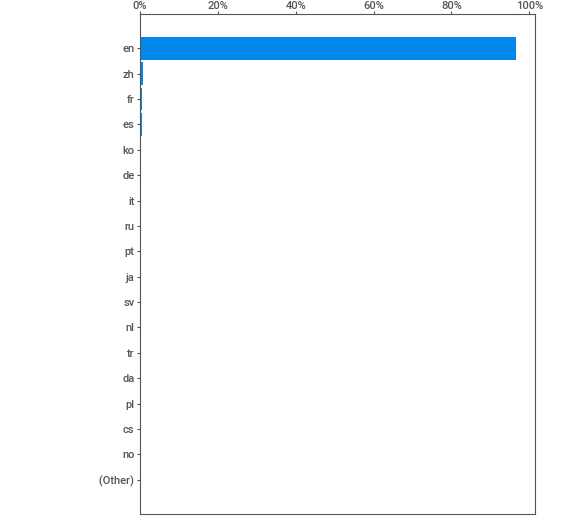
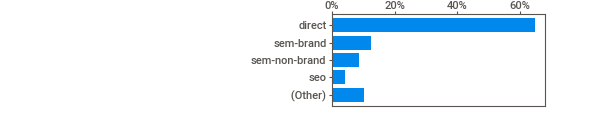
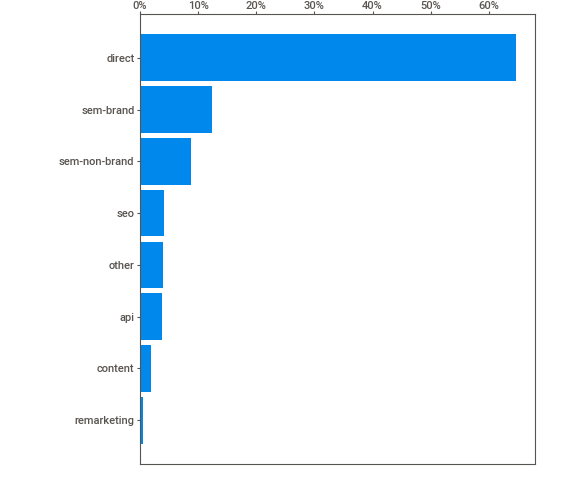
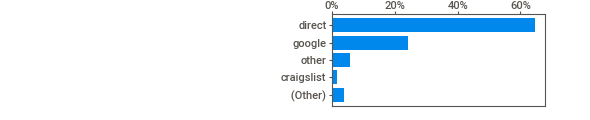
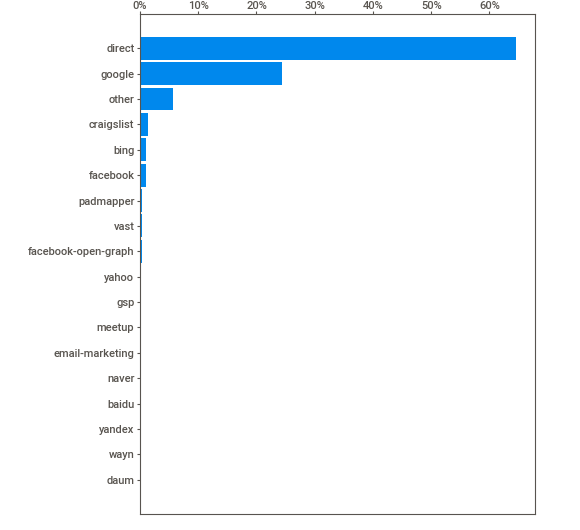
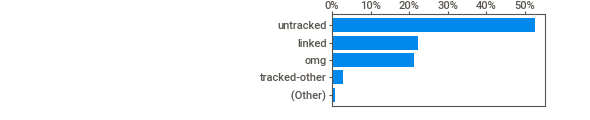
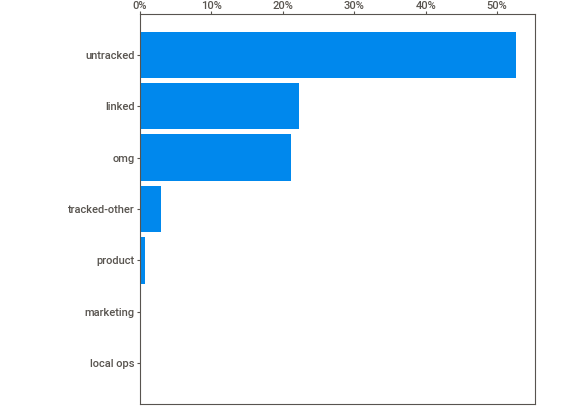
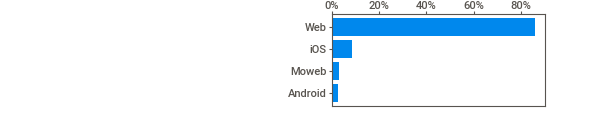
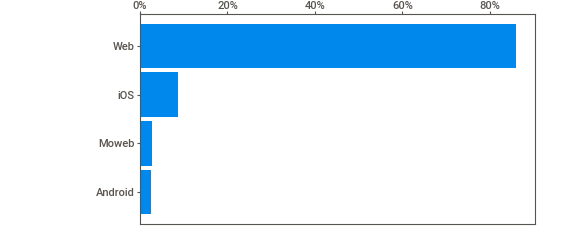
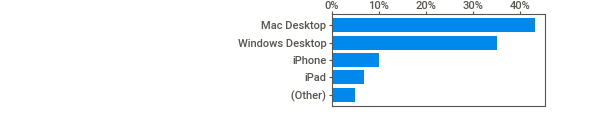
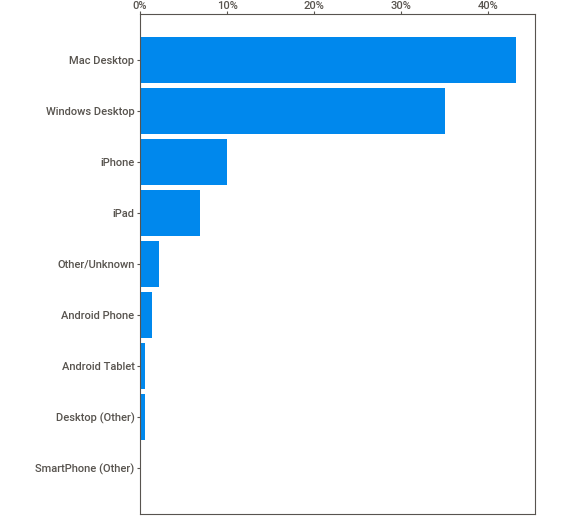
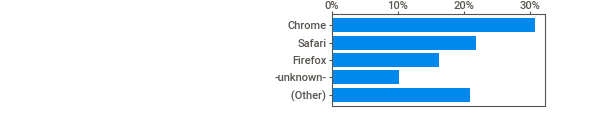
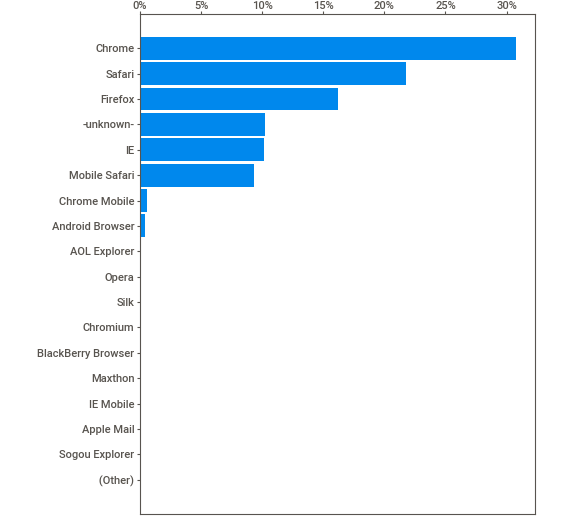
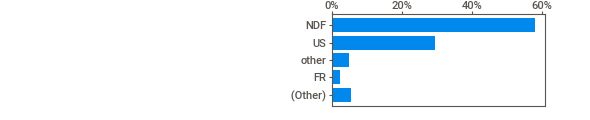
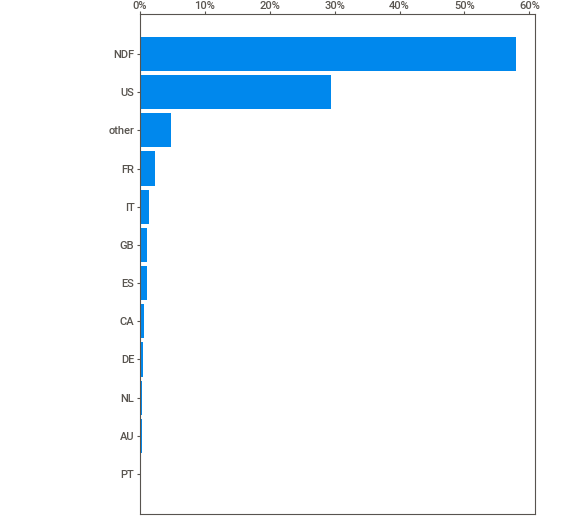
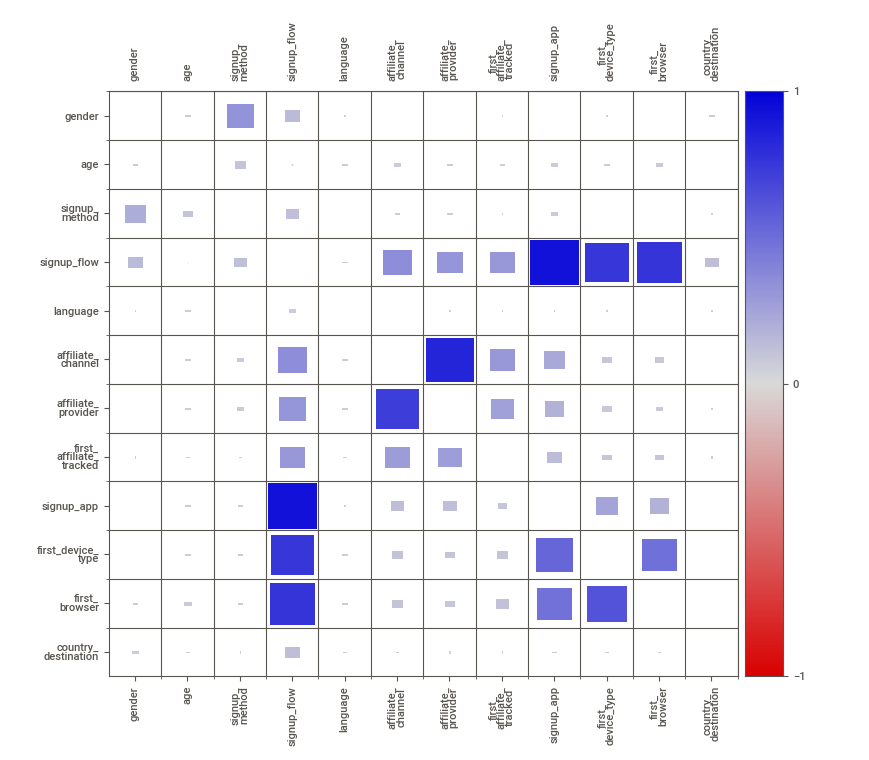
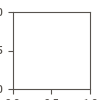

In [107]:
my_report = sv.analyze(df1)
my_report.show_notebook()

In [117]:
df_sessions1.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.00000
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.00000
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.00000
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.00000


In [113]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [120]:
from scipy.stats import chi2_contingency



def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [122]:
cat_attributes_sessions = df_sessions1.select_dtypes(include='object')

In [125]:
cat_attributes_list = df1.select_dtypes(include='object').drop( 'id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_list[ ref ], cat_attributes_list[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list



TypeError: list indices must be integers or slices, not str

p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: user_id                             |█▍        | [ 14%]   00:11 -> (01:10 left)p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
Feature: action                              |██▊       | 


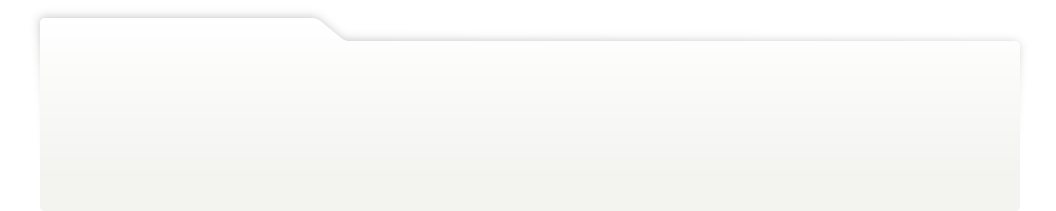
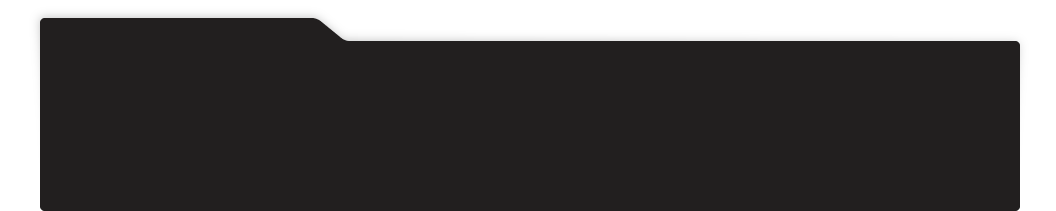
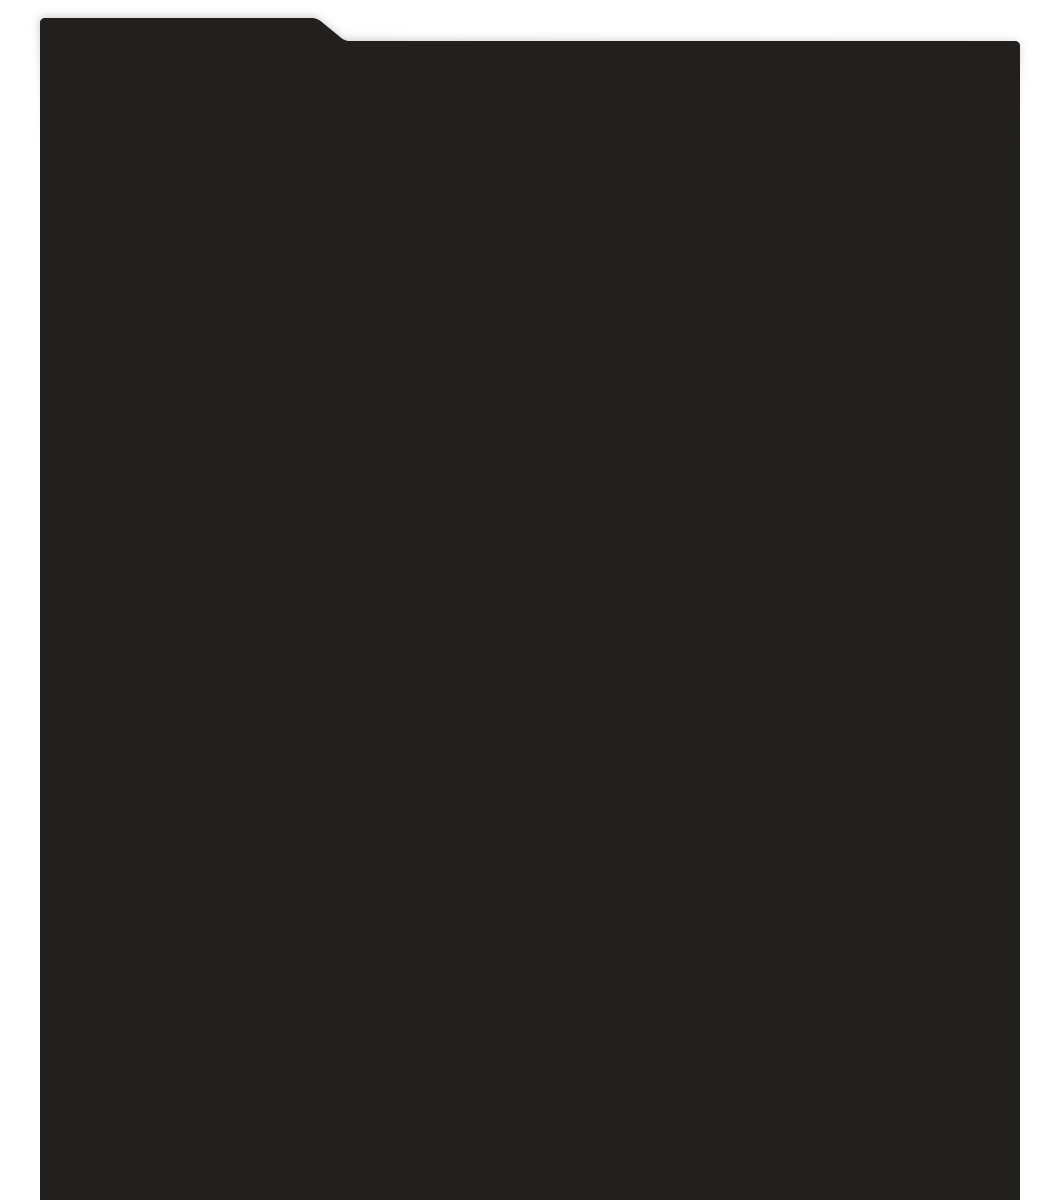
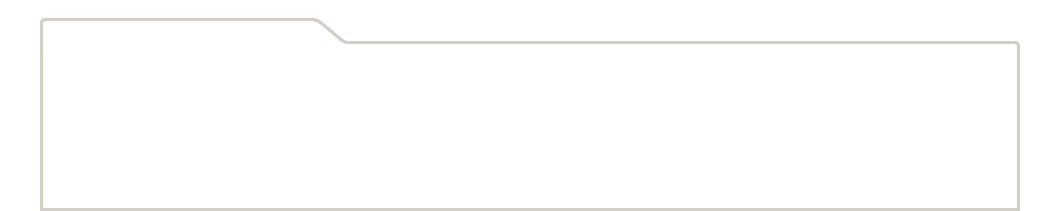
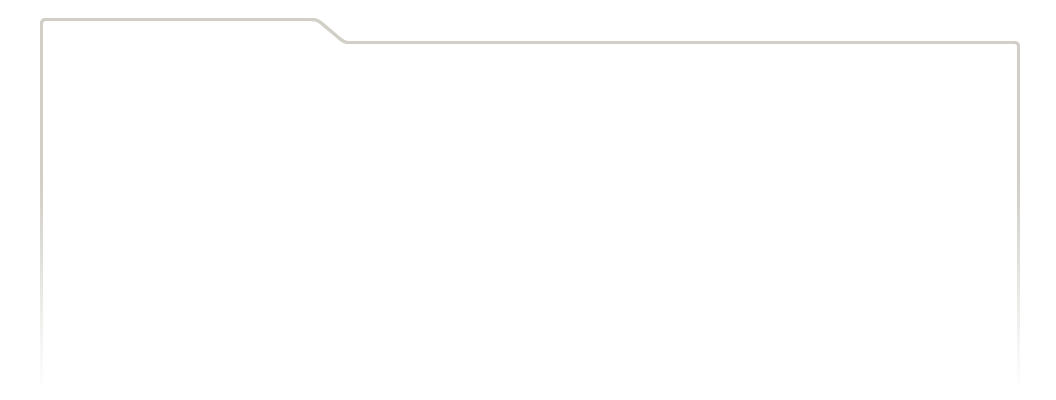
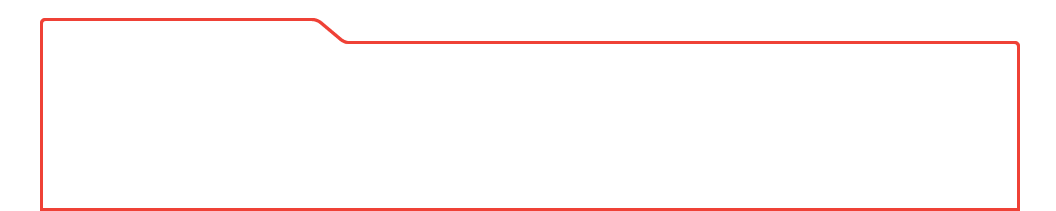
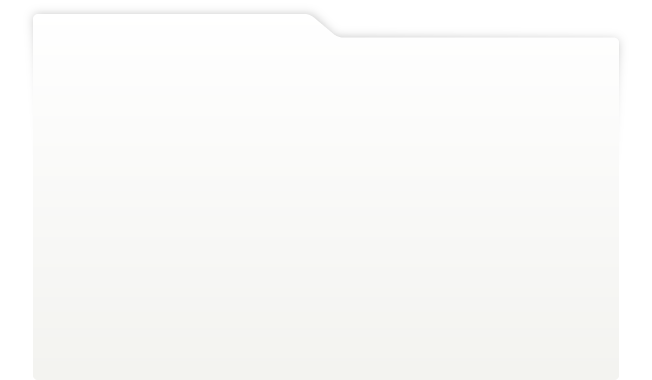
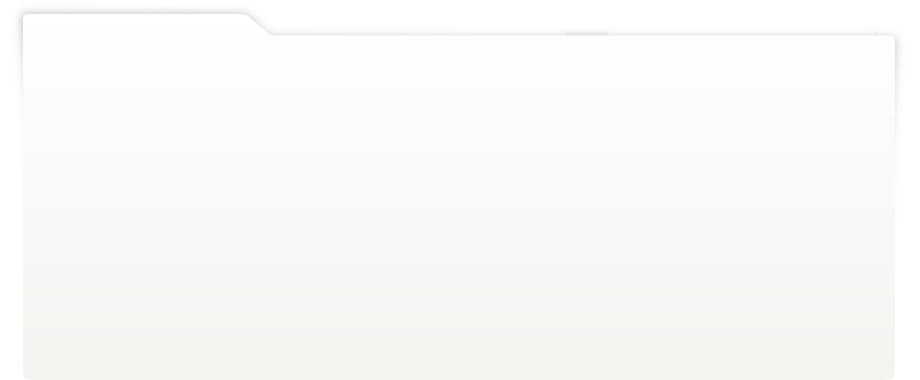
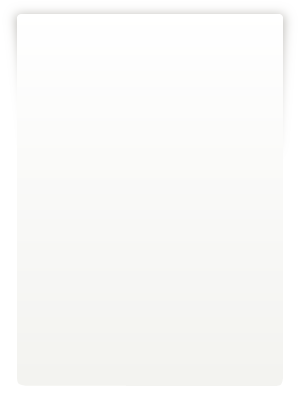
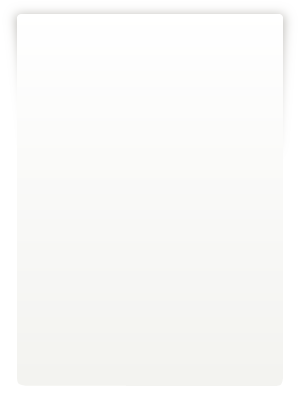
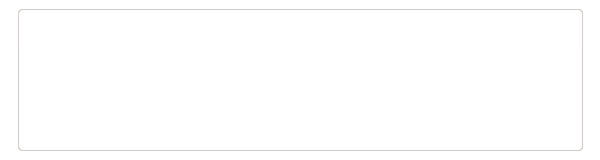
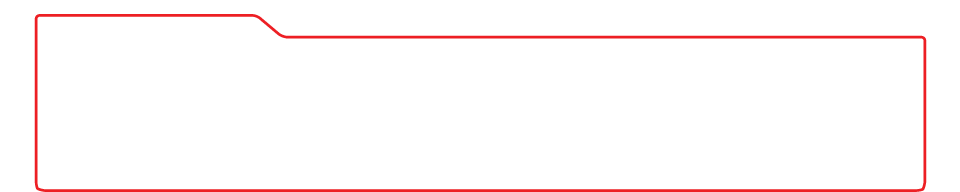
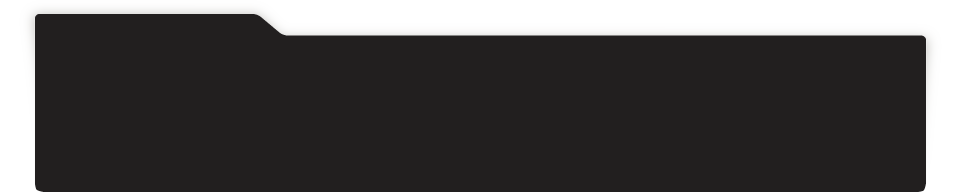
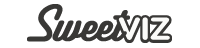
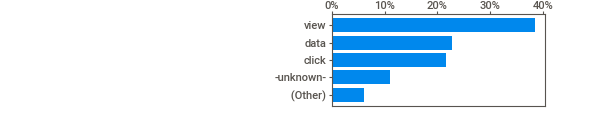
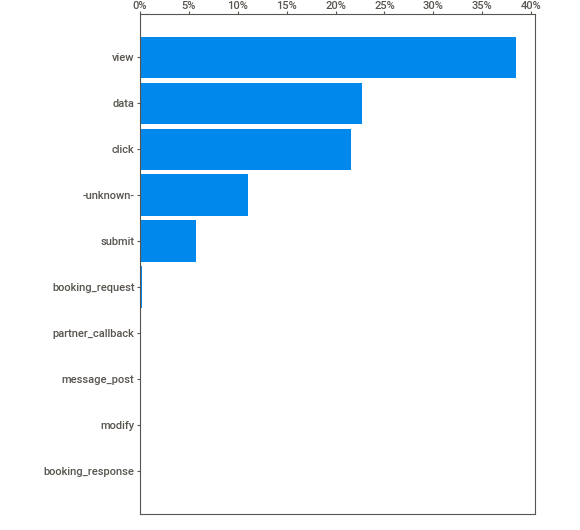
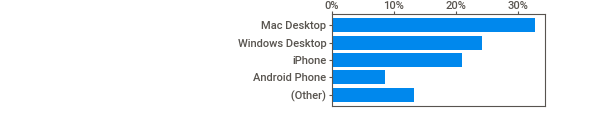
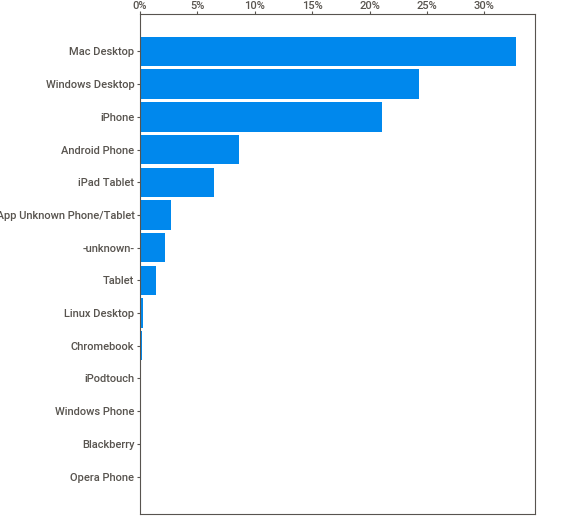
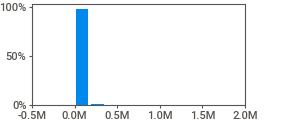
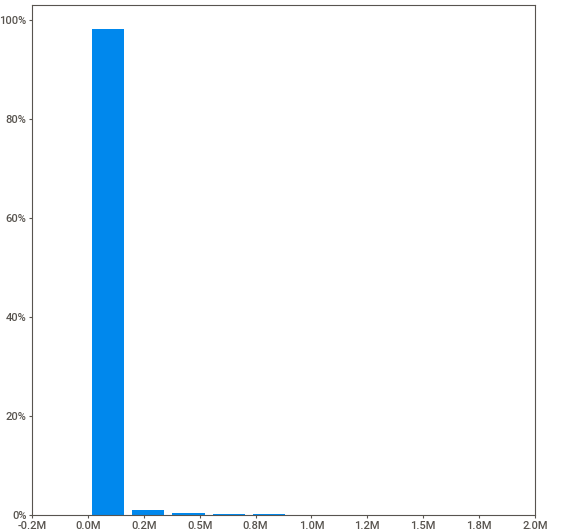
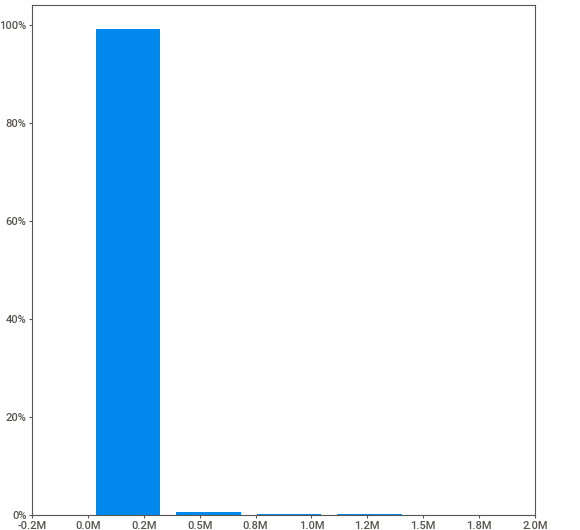
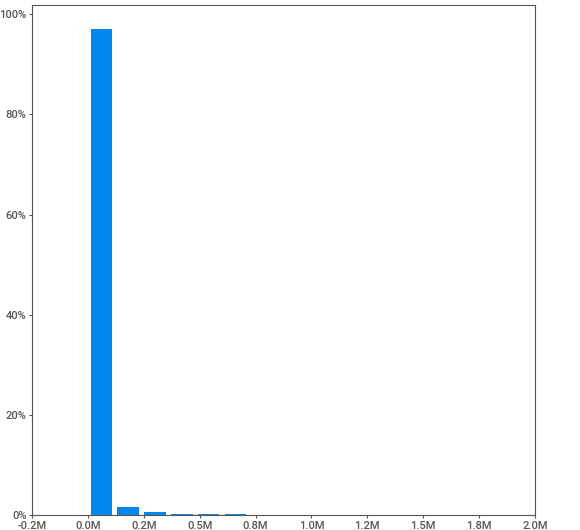
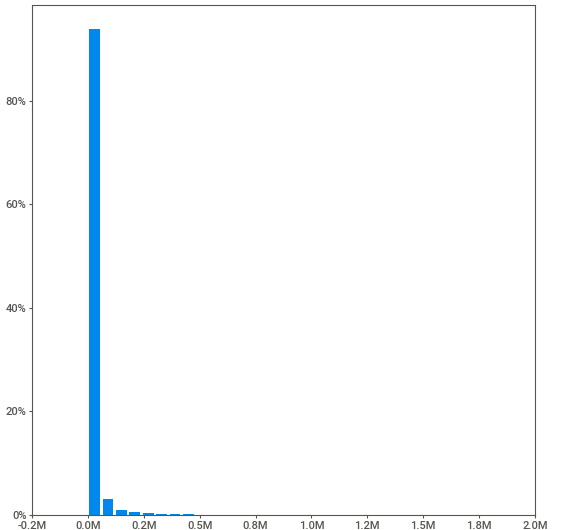
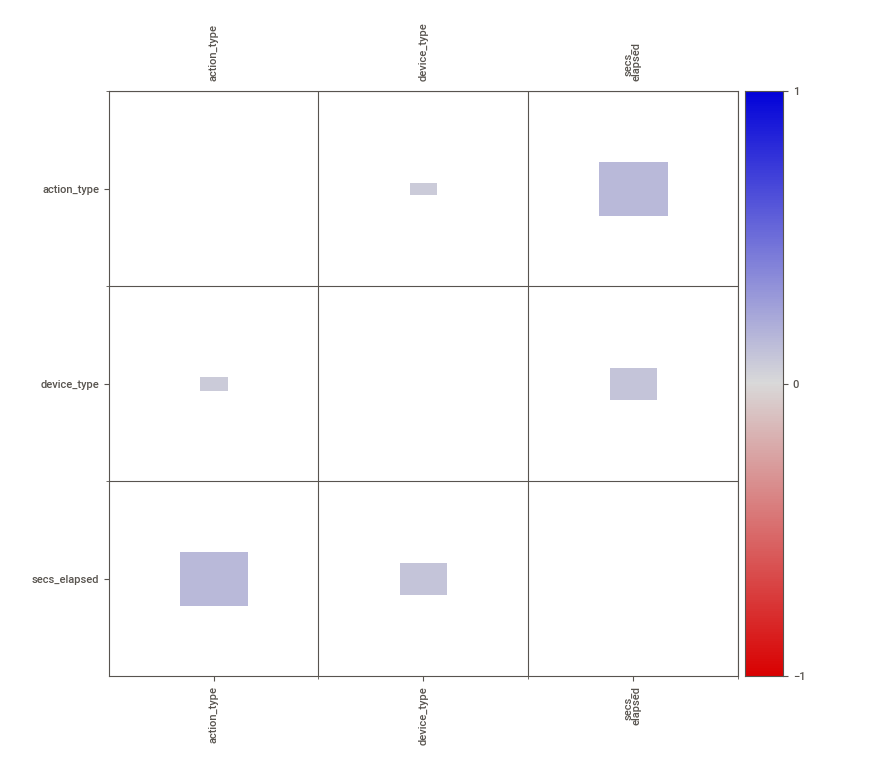
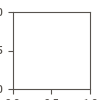

In [109]:
my_report = sv.analyze(df_sessions1)
my_report.show_notebook()

# 2.0 Feature Engineering

In [126]:
df2 = df1.copy()

In [127]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Creature nem features

In [140]:
# days from frist active up to first booking

df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days)


# days from frist active upt to account created
df2['days_from_first_active_until_created'] = (df2['date_account_created'] - df2['first_active']).apply( lambda x: x.days)


# days from account created up to first booking
df2['days_from_accounted_created_unilt_first_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days)

################################ First active ##################################


# year of first active
df2['year_first_active'] = df2['first_active'].dt.year


# month of first active
df2['month_first_active'] = df2['first_active'].dt.year


# day of first active
df2['day_first_active'] = df2['first_active'].dt.year


# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.year


# week of year first active
df2['day_of_year_first_active'] = df2['first_active'].dt.year


######################## Booking #####################

# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year


# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.year


# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.year


# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.year


# week of year first booking
df2['day_of_year_first_booking'] = df2['date_first_booking'].dt.year

#=================================== First Account Created ==============================
# year of first account_created
df2['year_first_account_created'] = df2['date_account_created'].dt.year


# month of first account_created
df2['month_first_account_created'] = df2['date_account_created'].dt.year


# day of first account_created
df2['day_first_account_created'] = df2['date_account_created'].dt.year


# day of week first account_created
df2['day_of_week_first_account_created'] = df2['date_account_created'].dt.year


# week of year first account_created
df2['day_of_year_first_account_created'] = df2['date_account_created'].dt.year

In [ ]:
# year of first account_created
df2['year_first_account_created'] = df2['date_first_account_created'].dt.year


# month of first account_created
df2['month_first_account_created'] = df2['date_first_account_created'].dt.year


# day of first account_created
df2['day_first_account_created'] = df2['date_first_account_created'].dt.year


# day of week first account_created
df2['day_of_week_first_account_created'] = df2['date_first_account_created'].dt.year


# week of year first account_created
df2['day_of_year_first_account_created'] = df2['date_first_account_created'].dt.year

In [136]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_booking,days_from_first_active_until_created,days_from_accounted_created_unilt_first_booking
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,2293,466,2293
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,2228,732,2228
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,419,476,419
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,1043,765,1043
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,72,280,72


In [142]:
df2.shape

(207386, 35)

# 3.0 Data Filtering

In [147]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [149]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[ (df3['age']>15) & (df3['age']<120) ]

# secs_elapsed - There is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed']>0 ]

# 4.0 Data Prep

In [193]:
df4 = df3.copy()


In [194]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
     ---------------------------------------- 0.0/226.0 kB ? eta -:--:--
     -------------------------------------  225.3/226.0 kB 6.9 MB/s eta 0:00:01
     -------------------------------------- 226.0/226.0 kB 4.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [214]:
from imblearn import over_sampling as oversamp
from imblearn import combine as c
from sklearn.preprocessing import OneHotEncoder

## 4.1 Smote+Tomek

In [211]:
ohe = OneHotEncoder()

col_num = df4.select_dtypes( include=["int64", "float64"]).columns.tolist()

col_cat = df4.select_dtypes( exclude=["int64", "float64", "datetime64[ns]"]).drop(['id', 'country_destination'], axis=1).columns.tolist()

df4_dummy = pd.DataFrame(ohe.fit_transform( df4[col_cat]).toarray(), index=df4.index )

df42 = pd.concat( [df4[col_num], df4_dummy] , axis=1)

In [212]:
col_cat

['gender',
 'age',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']

In [206]:


# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy= "all", random_state=42 )

# apply sampler
X_under, y_under = oversampling.fit_resample( df42, df4['country_destination'] )

## 4.3 SMOTE + TOMEKLINK

In [219]:
ratio_balanced = {'NDF': 119810,
 'US': 60800,
 'other': 9935 * 10,
 'FR': 4881 * 25,
 'IT': 2776 * 25,
 'GB': 2285 * 25,
 'ES': 2203 * 25,
 'CA': 1385 * 30,
 'DE': 1033  * 30,
 'NL': 746  * 30,
 'AU': 526  * 50,
 'PT': 213  * 70}
ratio_balanced

{'NDF': 119810,
 'US': 60800,
 'other': 99350,
 'FR': 122025,
 'IT': 69400,
 'GB': 57125,
 'ES': 55075,
 'CA': 41550,
 'DE': 30990,
 'NL': 22380,
 'AU': 26300,
 'PT': 14910}

In [ ]:
smt = c.SMOTETomek( sampling_strategy='auto', random_state=42, n_jobs=-1)

X_smt, y_smt = smt.fit_resample( df42 , df4['country_destination'] )

In [ ]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1)
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index)


# join numerical categorical
df46 = pd.concat( [df43, df45] , axis=1)
df46['country_destination'] = y_smt

In [208]:
y_under.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

In [150]:

#dummy variable
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1 ) )

#join id and country destination
df4 = pd.concat( [df4[['id', 'country_destination']], df4_dummy], axis=1 )

In [151]:
df4.shape

(206593, 156)

# 5.0 Feature Selection

In [181]:
df5 = df4.copy()

In [182]:
cols_drop = ['date_account_created', 'timestamp_first_active', "date_first_booking", "first_active","date_first_booking",]
df5 = df5.drop( cols_drop , axis=1)

# 5.0 Machine Learning Model

In [183]:
df6 = df5.copy()

In [184]:
X = df6.drop( ["country_destination","id"] , axis=1 )
y = df6['country_destination'].copy()

In [185]:
Xtrain, Xtest, ytrain, ytest = train_test_split( X, y, test_size = 0.2, random_state=42 )

## 5.1 Baseline Model

In [186]:
country_list = np.sort(y.unique())
country_list

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [187]:
weights_country = y.value_counts(normalize=True).sort_index()
weights_country

AU      0.00255
CA      0.00670
DE      0.00500
ES      0.01066
FR      0.02363
GB      0.01106
IT      0.01344
NDF     0.57993
NL      0.00361
PT      0.00103
US      0.29430
other   0.04809
Name: country_destination, dtype: float64

In [188]:
yhat_random = random.choices( population=country_list, weights=weights_country ,k=len(Xtest))

In [189]:
# accuracy

acc_nn = accuracy_score(ytest, yhat_random)

bacc_nn = balanced_accuracy_score(ytest, yhat_random)

kappa_nn = cohen_kappa_score(ytest, yhat_random)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)


0.42583315181877585 
 0.0841742689718028 
 -0.0023356946743893214


Confusion matrix, without normalization
[[13926  7049  1222   137   544   306   275   318    20    81   133    51]
 [ 7017  3520   607    78   302   105   136   175    12    41    59    39]
 [ 1165   556    97    12    48    17    15    25     1     6     7     5]
 [  174    96     8     1     7     3     3     4     0     0     2     1]
 [  558   292    38     7    26    11    10     6     0     1     4     2]
 [  278   116    25     1    12     7     6     4     1     1     1     1]
 [  266   121    21     1     8     6     9     4     0     3     1     2]
 [  343   170    31     5    10     4     6     7     0     4     3     2]
 [   30     9     2     0     3     0     1     1     0     0     0     0]
 [   89    38     3     1     0     1     1     3     0     1     2     1]
 [  115    49    10     1    11     1     3     4     0     2     1     0]
 [   49    35     3     0     4     2     0     2     0     0     0     0]]


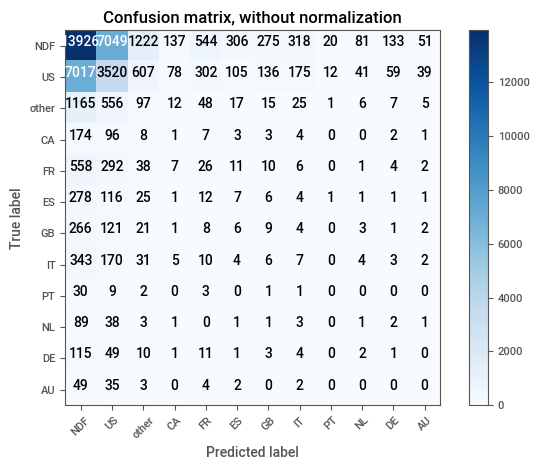

In [190]:
cnf_matrix = confusion_matrix(ytest, yhat_random,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

## 5.2 Neural Network Model

In [191]:

ohe = OneHotEncoder()
ytrain_nn = ohe.fit_transform( ytrain.values.reshape( -1, 1 ) ).toarray()


In [192]:
model = ml.Sequential()
model.add( l.Dense( 256, input_dim = Xtrain.shape[1], activation = "relu" ) )
model.add( l.Dense( 12, activation="softmax") )

#model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

#train model
model.fit( Xtrain, ytrain_nn, epochs=100 )

Epoch 1/100
5165/5165 [==============================] - 15s 2ms/step - loss: 9.0723 - accuracy: 0.7854
Epoch 2/100
5165/5165 [==============================] - 17s 3ms/step - loss: 0.8254 - accuracy: 0.8329
Epoch 3/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5447 - accuracy: 0.8644
Epoch 4/100
5165/5165 [==============================] - 11s 2ms/step - loss: 0.5274 - accuracy: 0.8666
Epoch 5/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5212 - accuracy: 0.8685
Epoch 6/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5176 - accuracy: 0.8690
Epoch 7/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.5155 - accuracy: 0.8694
Epoch 8/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.5163 - accuracy: 0.8697
Epoch 9/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.5063 - accuracy: 0.8703
Epoch 10/100
5165/5165 [==============================] - 10s 2m

# 6.0 NN Performance

In [ ]:
# prediction
pred_nn = model.predict( Xtest )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
ytest_nn = ytest.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

427/427 [==============================] - 1s 3ms/step


In [ ]:
# accuracy

acc_nn = accuracy_score(ytest_nn, yhat_nn)

bacc_nn = balanced_accuracy_score(ytest_nn, yhat_nn)

kappa_nn = cohen_kappa_score(ytest_nn, yhat_nn)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)

0.7098643197653098 
 0.09148376904356637 
 0.003565012830887282


In [ ]:
print(classification_report(ytest_nn, yhat_nn))

p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        90
          CA       0.00      0.00      0.00       210
          DE       0.00      0.00      0.00       176
          ES       0.00      0.00      0.00       344
          FR       0.50      0.00      0.01       742
          GB       0.00      0.00      0.00       356
          IT       0.25      0.00      0.00       399
          NL       0.00      0.00      0.00       107
          PT       0.00      0.00      0.00        26
          US       0.71      1.00      0.83      9704
       other       0.29      0.00      0.01      1481

    accuracy                           0.71     13635
   macro avg       0.16      0.09      0.08     13635
weighted avg       0.57      0.71      0.59     13635



p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[9669   16    2    2    2    2    8    1    1    0    1]
 [1470    7    0    0    0    0    3    0    1    0    0]
 [ 210    0    0    0    0    0    0    0    0    0    0]
 [ 737    0    0    2    0    0    2    1    0    0    0]
 [ 395    1    0    0    1    0    2    0    0    0    0]
 [ 341    0    0    0    1    0    1    0    1    0    0]
 [ 355    0    0    0    0    1    0    0    0    0    0]
 [ 107    0    0    0    0    0    0    0    0    0    0]
 [ 176    0    0    0    0    0    0    0    0    0    0]
 [  89    0    0    0    0    0    1    0    0    0    0]
 [  26    0    0    0    0    0    0    0    0    0    0]]


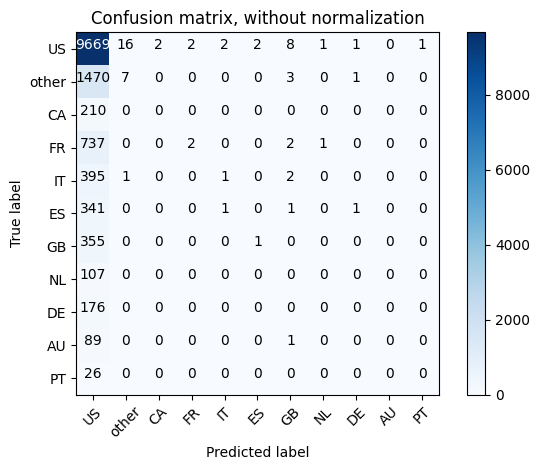

In [ ]:
cnf_matrix = confusion_matrix(ytest_nn, yhat_nn,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

In [ ]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( Xtrain, ytrain ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    Xtrain_fold = Xtrain.iloc[train_ix]
    ytrain_fold = ytrain.iloc[train_ix]
    
    x_val_fold = Xtrain.iloc[val_ix]
    y_val_fold = ytrain.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    ytrain_fold_nn = ohe.fit_transform( ytrain_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=Xtrain.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( Xtrain_fold, ytrain_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 2/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 3/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 4/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 5/5
341/341 [==============================] - 0s 1ms/step


In [ ]:
print( np.mean( balanced_acc_list), np.std( balanced_acc_list))
print( np.mean( kappa_acc_list), np.std( kappa_acc_list))

0.09169763963827852 0.0008134784013867776
0.0043365562461069596 0.0029099456969170216
